# Predicción a través de Suavizado Exponencial

El suavizado exponencial consiste en modelar una serie de tiempo como un sistema de ecuaciones diferenciales endógeno (sin entradas), el cual es descrito por:

\begin{equation}
\begin{array}{cllc}
s_i &=& \alpha (x_i - p_{i-k}) + (1 - \alpha) (s_{i-1} + t_{i-1}) & (1) \\
t_i &=& \beta (s_i - s_{i-1}) + (1 - \beta) t_{i-1} & (2) \\
p_i &=& \gamma (x_i - s_i) + (1 - \gamma) p_{i-k} & (3) \\
x_{i+h} &=& s_i + h t_i + p_{i-h+k} & (4)
\end{array}
\end{equation}

En específico, estas ecuaciones determinan:

    (1) la evolución de la memoria del sistema o suavizado en función del estado actual, la estacionalidad, valores pasados y la tendencia
    (2) la evolución de la tendencia del sistema (mira como va cambiando el suavizado)
    (3) la evolución de la estacionalidad del evento (mira la diferencia entre el suavizado y el valor actual)
    (4) salida del sistema donde se toma en cuenta el valor actual, la tendencia y estacionalidad


In [1]:
# extraer series de tiempo
import sys
sys.path.append("../scripts/")
from carga_datos import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file1 = "../data/PAULA/DEL MAULE/LINARES/Linares-01-01-2010-30-06-2010.xls"
file2 = "../data/PAULA/DEL MAULE/LINARES/Linares-01-07-2009-31-12-2009.xls"

df1 = read_year(file1, file2)
print('columnas: {}'.format(list(df1.columns)))
df1.head()

-> drop repeated, before len:  31501
-> after len:  31501
Hora          31501
Temp.         31501
Hum.          31501
Dir.Viento    31501
Vel.Viento    31501
Precip.       31501
Rad.Sol       31501
P.Atm         31501
Estacion      31501
Mes           31501
Dia           31501
dtype: int64
columnas: ['Hora', 'Temp.', 'Hum.', 'Dir.Viento', 'Vel.Viento', 'Precip.', 'Rad.Sol', 'P.Atm', 'Estacion', 'Mes', 'Dia']


,Hora,Temp.,Hum.,Dir.Viento,Vel.Viento,Precip.,Rad.Sol,P.Atm,Estacion,Mes,Dia
0,0,7.3,96.7,32,1.3,0.0,1,1002.4,Invierno,Julio,2009-07-01
1,15,6.9,97.1,42,0.9,0.0,1,1002.4,Invierno,Julio,2009-07-01
2,30,7.1,97.3,32,1.3,0.2,1,1002.6,Invierno,Julio,2009-07-01
3,45,7.0,97.1,18,1.3,0.0,1,1002.7,Invierno,Julio,2009-07-01
4,60,6.9,97.0,28,1.3,0.0,1,1002.9,Invierno,Julio,2009-07-01


In [3]:
# def suavizado(serie, alpha, beta, gamma, k=24*4, paso=0):
#     """
#     Input:
#         serie: serie de tiempo en arreglo numpy, con informacion disponible
#         alpha: parametro de ajuste para suavizado
#         beta: parametro de ajuste para tendencia
#         gamma: parametro de ajuste para estacionalidad
#         k: cada cuanto afecta la estacionalidad al estado actual
#         paso: a cuantos pasos se quiere predecir
#     Return:
#         ajuste: arreglo de mismo tamanho que la serie con el suavizado
#         pronostico: arreglo con el pronostico de la serie
#     """
#     s = []
#     t = []
#     p = []
    
#     s.append(0.5)
#     t.append(0.5)
#     p.append(0)
    
#     # suavizado
#     for i, x in enumerate(serie):
#         if i <= k:
#             s.append(alpha * (x) + (1 - alpha) * (s[i-1] + t[i-1]))
#             t.append(beta * (s[i] - s[i-1]) + (1 - beta) * t[i-1])
#             p.append(p[i-1])
#         else:
#             s.append(alpha * (x - p[i-k]) + (1 - alpha) * (s[i-1] + t[i-1]))
#             t.append(beta * (s[i] - s[i-1]) + (1 - beta) * t[i-1])
#             p.append(gamma * (x - s[i]) + (1 - gamma) * p[i-k])

#     a = len(s)
#     s_i = s[-1]
#     t_i = t[-1]
    
#     # pronostico
#     for i in range(a, a + paso):
#         h = i - a
#         x = s_i + h * t_i + p[a - k + i % k]
# #         s.append(x)
#         s.append(x)
# #         t.append(beta * (s[i] - s[i-1]) + (1 - beta) * t[i-1])
# #         p.append(gamma * (x / s[i]) + (1 - gamma) * p[i-k])
        
# #         print(i-a)
# #         s.append(x)
# #         t.append(beta * (s[i] - s[i-1]) + (1 - beta) * t[i-1])
# #         p.append(gamma * (x - s[i-1]) + (1 - gamma) * p[i-k])
        
# #     for h in range(paso):
# #         s.append(s_i + h * t_i + p[a - k + h])
# #         p.append(gamma * (x - s_i) + (1 - gamma) * p[a - k + h])
        
#     return [s[:-paso-1], s[-paso:], t, p]

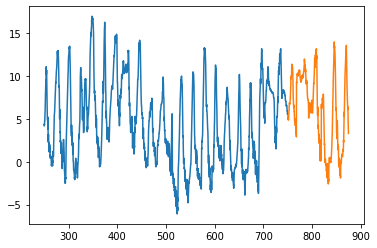

In [3]:
aux = []
suma = 0
for i in range(len(df1)):
    aux.append(suma)
    suma += 15 / 60
TIEMPO = aux
temp = [x for x in df1['Temp.']]
tiempo = np.arange(len(temp))
# print(1 / (400 / np.max(tiempo) * np.pi))
# temp = np.sin(tiempo / np.max(tiempo) * 400 * np.pi)

idx = 1000
n_train = idx + 2000
n_test = n_train + 500

train_ = temp[idx : n_train]
t_train = TIEMPO[idx : n_train]

test_ = temp[n_train : n_test]
t_test = TIEMPO[n_train : n_test]

plt.plot(t_train, train_)
plt.plot(t_test, test_)

In [4]:
# pasos = 200
# suave, prediccion, t, p = suavizado(train_, alpha=0.03, beta=0.02, gamma=0.3, k=75, paso=pasos)

In [5]:
# plt.plot(t_train, suave, '-b', label='suavizado')
# plt.plot(t_train, train_, '-r', label='datos')
# # plt.plot(t_test[:pasos], prediccion, '-+b', label='prediccion')
# # plt.plot(t_test[:pasos], test_[:pasos], '-.r', label='datos')
# plt.legend()
# plt.show()

# plt.plot(t_test[:pasos], prediccion, '-+b', label='prediccion')
# plt.plot(t_test[:pasos], test_[:pasos], '-.r', label='datos')
# plt.legend()
# plt.show()

# plt.plot(t), plt.show()
# plt.plot(p), plt.show()

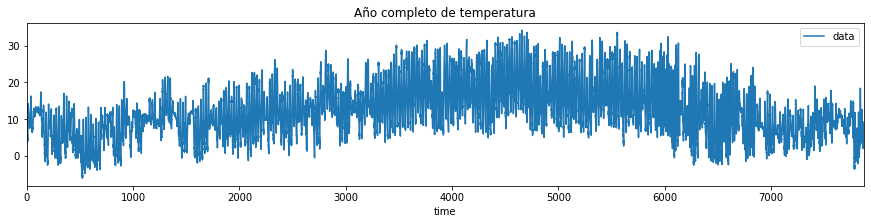

In [6]:
data = {'time':TIEMPO, 'data':temp}
df = pd.DataFrame(data, columns=['time','data']).set_index('time')
df.plot(figsize=(15,3))
plt.title('Año completo de temperatura')
train = df.iloc[:-1000]
test = df.iloc[-1000:]
pred = test.copy()

win = 24*4

def plot_rolling(df, win):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df.data, label='raw data')
    ax[0].plot(df.data.rolling(window=win).mean(), label="rolling mean");
    ax[0].plot(df.data.rolling(window=win).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=win).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=win).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=win).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=win).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

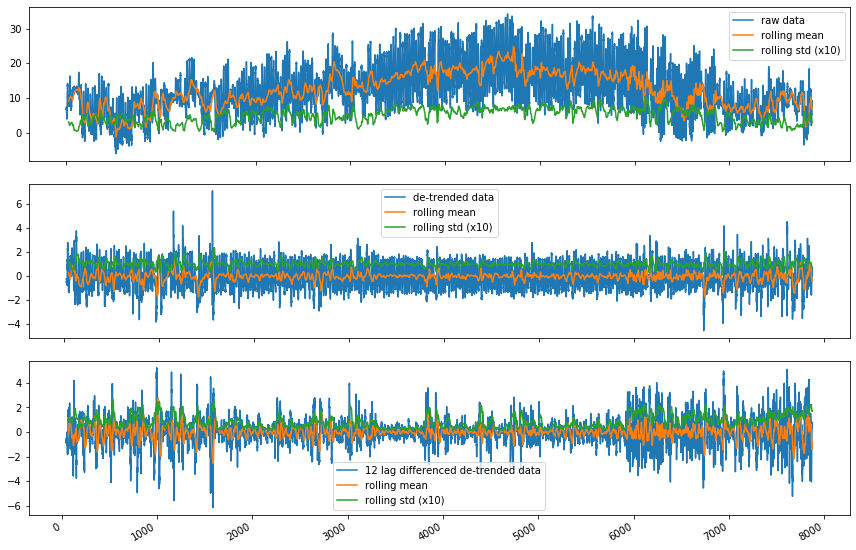

In [7]:
df['z_data'] = (df.data - df.data.rolling(window=win).mean()) / df.data.rolling(window=win).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(win)

plot_rolling(df, win)

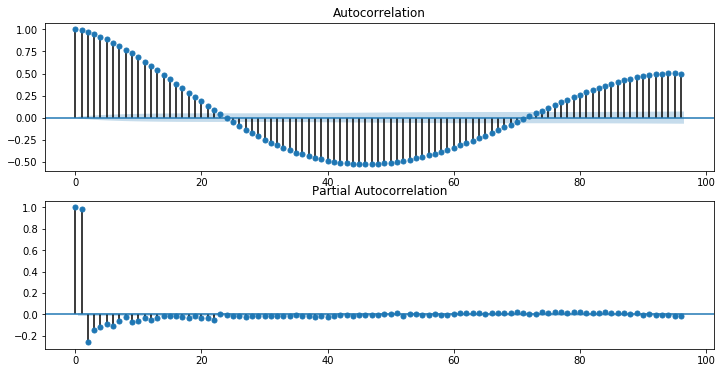

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
win = 24 * 4
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.z_data.dropna(), ax=ax[0], lags=win)
ax[1] = plot_pacf(df.z_data.dropna(), ax=ax[1], lags=win)

In [36]:
data = {'time':TIEMPO, 'data':temp}
df = pd.DataFrame(data, columns=['time','data']).set_index('time')
ventana_de_suavizado = 12
# df['data'] = df.data.rolling(window=ventana_de_suavizado).mean()

# suavizar la sennal

n_ = round(24 * 4 * 29)
n_train = n_ + round(24 * 4 * 40) + 4 * 5
n_pred = round(24 * 4 * 3)
train = df.iloc[n_:n_train]
test = df.iloc[n_train:n_train + n_pred]

win = round(24 * 4)

pred = test.copy()

/home/martin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/martin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/martin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/martin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/martin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization faile

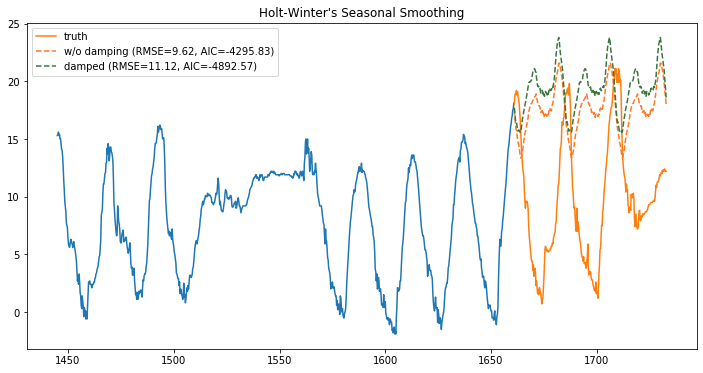

In [37]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=win)
# model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=win, damped=True)

model = ExponentialSmoothing(train, trend=None, seasonal="add", seasonal_periods=win)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=win, damped=True)

fit = model.fit()
pred = fit.forecast(n_pred)
fit2 = model2.fit()
pred2 = fit2.forecast(n_pred)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-3*(n_pred):], train.values[-3*(n_pred):]);
# ax.plot(train.index, train.values);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

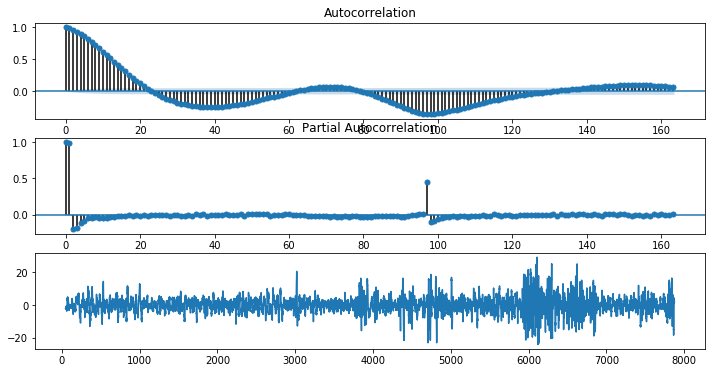

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Stationary data
df['station'] = df.data - df.data.rolling(win).mean()

fig, ax = plt.subplots(3, figsize=(12,6))
x = (df.station.dropna() - df.station.dropna().shift(win)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=win*1.7)
ax[1] = plot_pacf(x, ax=ax[1], lags=win*1.7)
ax[2].plot(x)

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/home/martin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


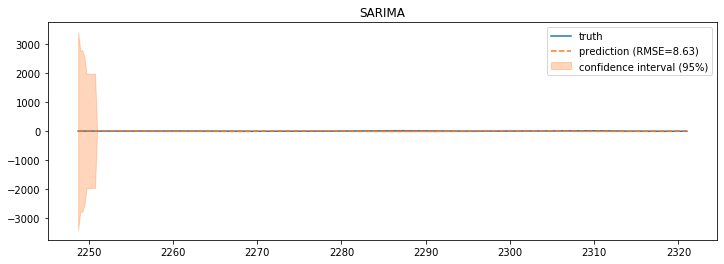

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

n_ = 1825
n_train = n_ + 400
n_pred = 24 * 4

win = 24 * 4

train_st = df.ix[n_:n_train, "station"]
test_st = df.ix[n_train:n_train + n_pred, "station"]
# print(len(test_st))

sarima_model = SARIMAX(train_st, order=(0, 1, 2), seasonal_order=(0, 1, 2, 3, 24*4), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.get_prediction(end=3*n_pred+1)
p = sarima_pred
# print(df.data.iloc[n_train:n_train + n_pred].rolling(win).mean().dropna().values)
# predicted_means = p.predicted_mean + df.data.iloc[-4*n_pred:-1].rolling(win).mean().dropna().values
predicted_means = p.predicted_mean + test_st.rolling(win).mean().dropna().values
predicted_intervals = p.conf_int(alpha=0.05)
# lower_bounds = predicted_intervals['lower station'] + df.data.iloc[-4*n_pred:-1].rolling(win).mean().dropna().values
# upper_bounds = predicted_intervals['upper station'] + df.data.iloc[-4*n_pred:-1].rolling(win).mean().dropna().values

lower_bounds = predicted_intervals['lower station'] + test_st.rolling(win).mean().dropna().values
upper_bounds = predicted_intervals['upper station'] + test_st.rolling(win).mean().dropna().values

sarima_rmse = np.sqrt(np.mean(np.square(test_st.values[-3*n_pred-2:] - p.predicted_mean.values)))

fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot(df.data.index[100:-3*n_pred], df.data.values[100:-3*n_pred]);
# ax.plot(test_st.index[-3*n_pred:], test_st.values[-3*n_pred:] + df.data.iloc[-4*n_pred:-1].rolling(win).mean().dropna().values, label='truth');
ax.plot(test_st.index[-3*n_pred-2:], test_st.values[-3*n_pred-2:] + test_st.rolling(win).mean().dropna().values, label='truth');
ax.plot(test_st.index[-3*n_pred-2:], predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.2f})".format(sarima_rmse));
ax.fill_between(test_st.index[-3*n_pred-2:], lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)");
ax.legend();
ax.set_title("SARIMA");